In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Entender el dataset

In [ ]:
df = pd.read_csv("../data/sabbatic_saas_churn_dataset.csv")
print(df.info())
print("---------5 primeros registros---------")
print(df.head())
print("---------filas y columnas---------")
print(df.shape)

<class 'pandas.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company_id               500 non-null    int64  
 1   months_active            500 non-null    int64  
 2   monthly_price            500 non-null    int64  
 3   users_count              500 non-null    int64  
 4   tickets_per_month        500 non-null    int64  
 5   logins_per_month         500 non-null    int64  
 6   mobile_usage_ratio       500 non-null    float64
 7   api_usage                500 non-null    int64  
 8   support_tickets_last_3m  500 non-null    int64  
 9   churn                    500 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 39.2 KB
None
---------5 primeros registros---------
   company_id  months_active  monthly_price  users_count  tickets_per_month  \
0           1             39             49          194                890   
1    

# Calidad de datos

In [13]:
## Cuantos valores nulos hay
print(df.isnull().sum())

## Cuantos duplicados hay
print("Duplicados:",df.duplicated().sum())

company_id                 0
months_active              0
monthly_price              0
users_count                0
tickets_per_month          0
logins_per_month           0
mobile_usage_ratio         0
api_usage                  0
support_tickets_last_3m    0
churn                      0
dtype: int64
Duplicados: 0


# Análisis del churn

In [14]:
df["churn"].value_counts(normalize=True)

churn
0    0.856
1    0.144
Name: proportion, dtype: float64

El codigo anterior está diciendo cómo está distribuida la lealtad de tus clientes en el dataset. Aquí el desglose:
¿Qué significan los números?
El método .value_counts(normalize=True) convierte las frecuencias absolutas en proporciones (porcentajes expresados del 0 al 1).

0 (85.6%): El 85.6% de los registros corresponden a clientes que no han cancelado su servicio (se mantienen activos).

1 (14.4%): El 14.4% de los registros corresponden a clientes que sí cancelaron (churn).

Tres conclusiones clave:
La Tasa de Churn: Tu tasa de pérdida de clientes es del 14.4%. Dependiendo de tu industria, esto te dirá si tienes un problema grave de retención o si estás dentro de lo normal.

Clases Desbalanceadas: Tienes un dataset desbalanceado. Hay muchísimos más ejemplos de "clientes que se quedan" que de "clientes que se van".

El reto para la IA: Si planeas entrenar un modelo de Machine Learning con esto, ten cuidado. Un modelo "perezoso" podría simplemente predecir siempre 0 y tendría un 85.6% de precisión, pero fallaría totalmente en detectar a los clientes que realmente se van a ir (que es lo que te interesa).

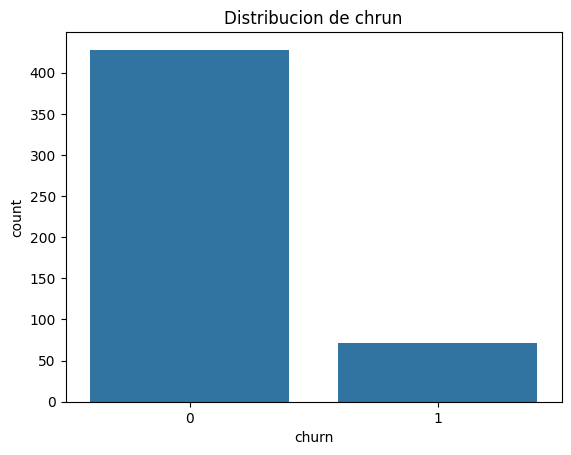

In [16]:
sns.countplot(x="churn", data=df)
plt.title("Distribucion de chrun")
plt.show()

En el grafico se ve claramente el desbalanceo

# Análisis univariante

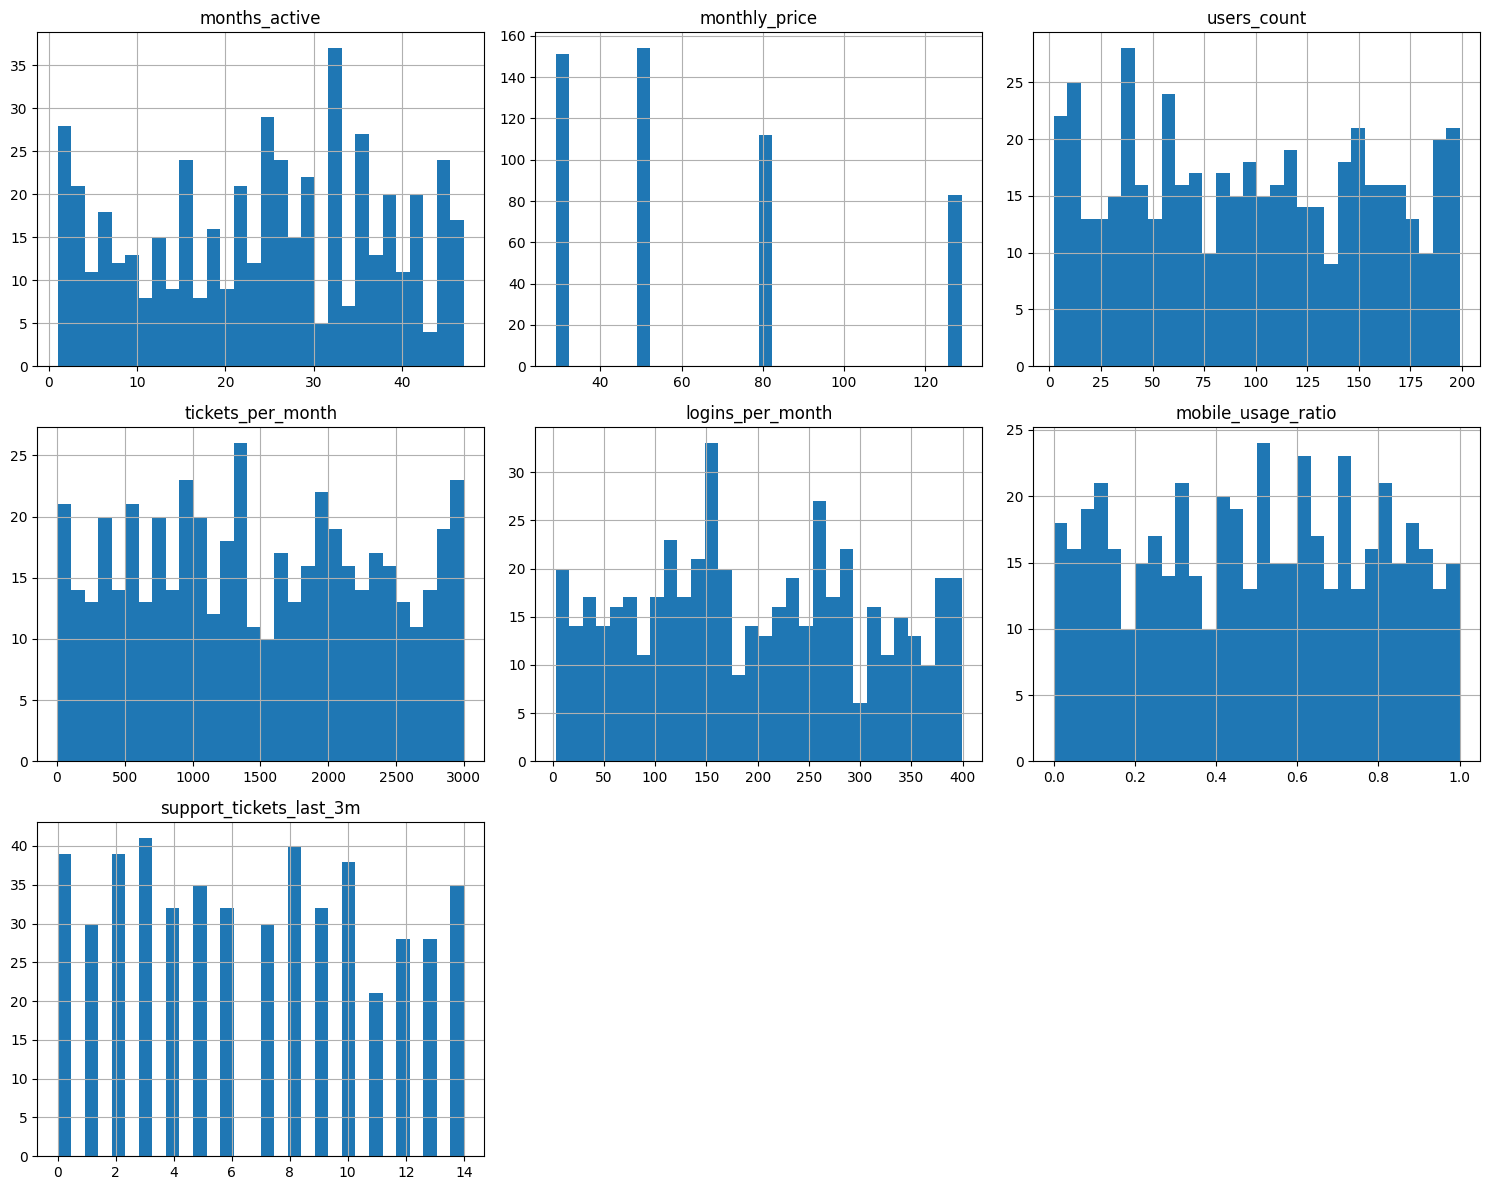

In [17]:
numerical_cols = [
    "months_active",
    "monthly_price",
    "users_count",
    "tickets_per_month",
    "logins_per_month",
    "mobile_usage_ratio",
    "support_tickets_last_3m"
]

df[numerical_cols].hist(bins=30, figsize=(15, 12))
plt.tight_layout()
plt.show()


1. Conclusiones de los gráficas
monthly_price (Precios): No es una distribución continua, sino discreta. Tienes cuatro planes de precios muy marcados (aproximadamente en 30, 50, 80 y 125). No hay outliers aquí, solo una oferta comercial definida.

mobile_usage_ratio: La distribución es bastante uniforme. Tienes casi la misma cantidad de usuarios que usan poco el móvil (0.0) que los que lo usan totalmente (1.0). Es una variable muy equilibrada.

months_active y logins_per_month: Parecen seguir una distribución algo aleatoria pero sin caídas bruscas. No se ve un grupo masivo de "clientes nuevos" frente a "clientes antiguos", está repartido.

support_tickets_last_3m: Se ve bastante actividad en todos los niveles.

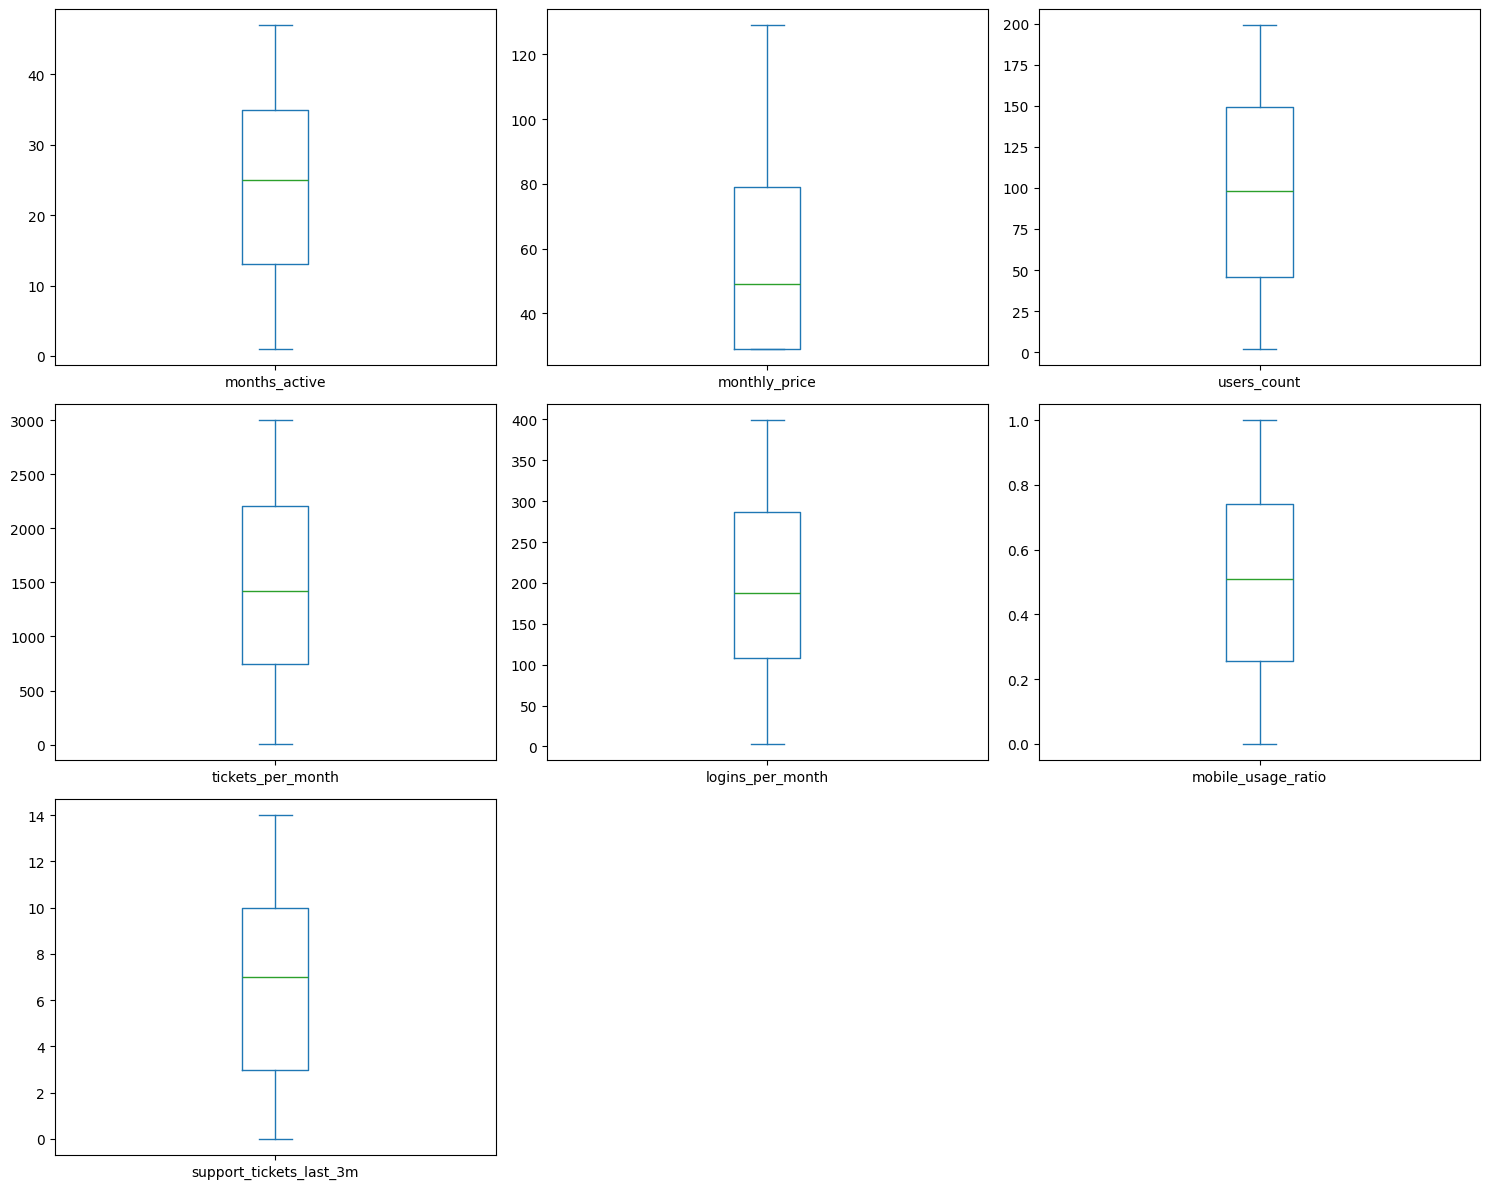

In [21]:
# Para ver Outliers

df[numerical_cols].plot(kind='box', subplots=True, layout=(3, 3), figsize=(15, 12), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

En estos graficos podemos observar que no hay outliers.
Interpretación rápida de lo que se ve:
La línea verde: Es la mediana. En casi todas las variables, está justo en el centro de la caja, lo que confirma que los datos son muy simétricos (no están sesgados a un lado).

monthly_price: Es la única "rara". La caja es asimétrica y la mediana está muy abajo. Esto confirma lo que hemos visto antes: hay muchos clientes en los planes baratos y unos pocos en el plan de 125, pero incluso ese plan de 125 no es un outlier, es simplemente el plan más alto.

# Churn vs variables numéricas

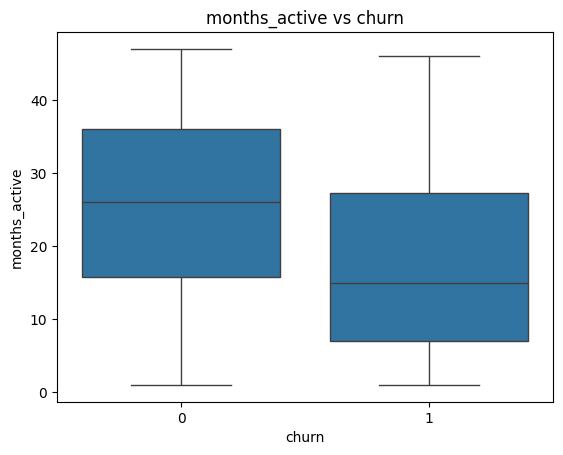

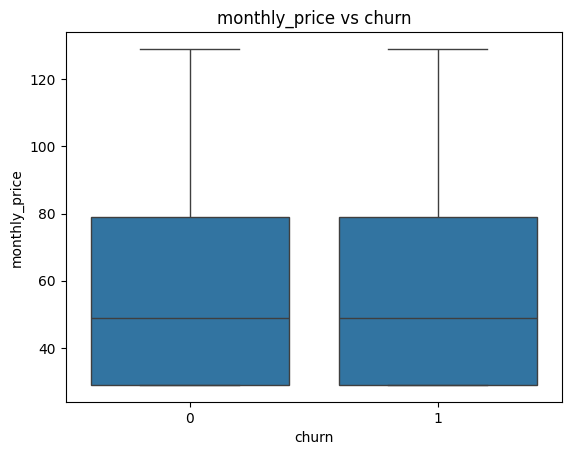

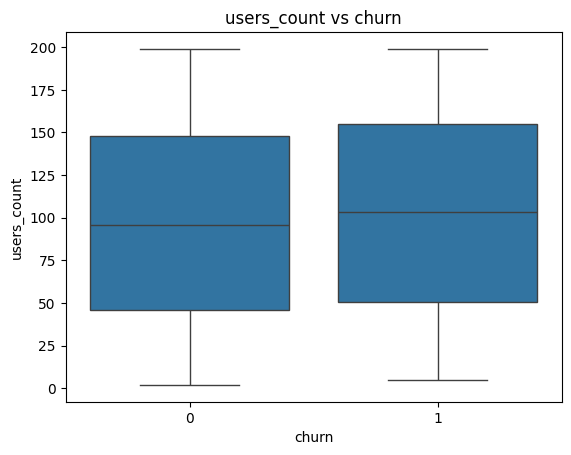

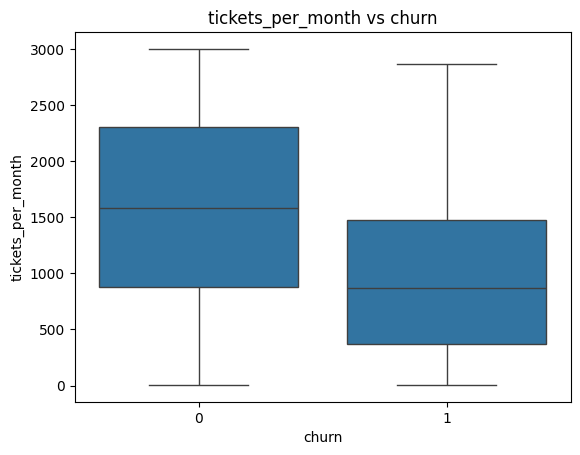

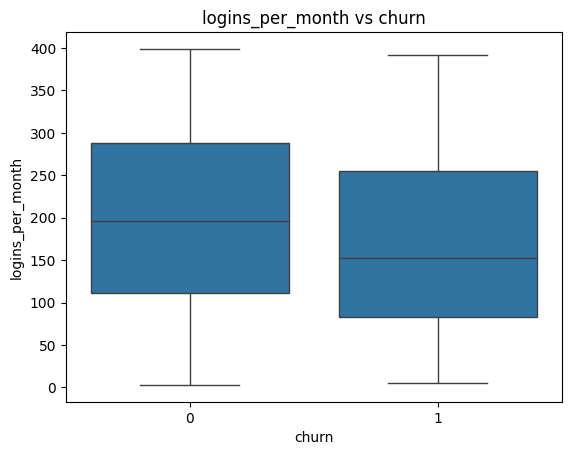

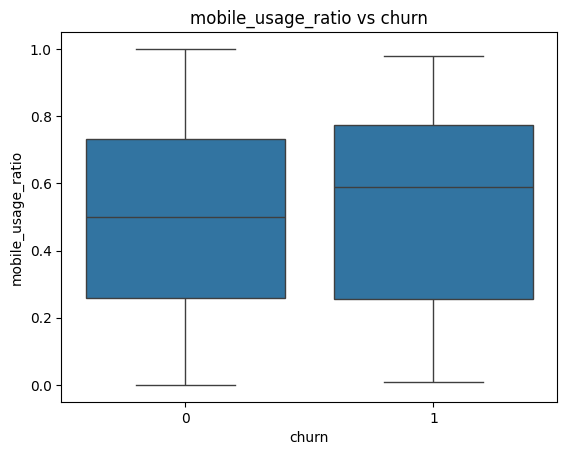

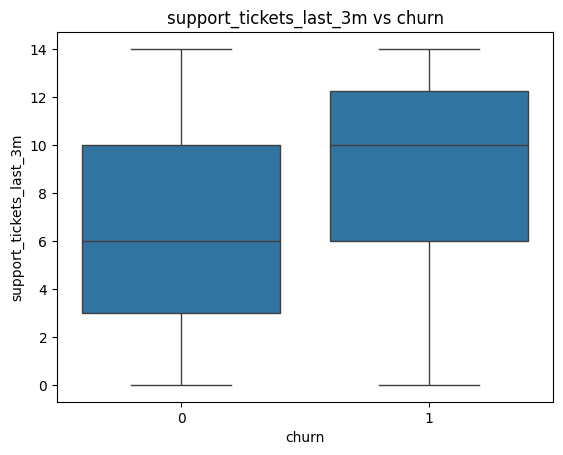

In [22]:
for col in numerical_cols:
    sns.boxplot(x="churn", y= col, data=df)
    plt.title(f"{col} vs churn")
    plt.show()

Al comparar los boxplots de los que se quedan (0) vs. los que se van (1), podemos identificar qué comportamientos "empujan" a un cliente a abandonar.

Aquí están las conclusiones más importantes:

1. El factor "Lealtad" (months_active)
Es una de las variables con mayor impacto visual.

Conclusión: Los clientes que hacen churn tienden a ser más nuevos.

Detalle: La mediana de los que se van (1) está notablemente más abajo que la de los que se quedan (0). Si un cliente sobrevive los primeros 25-30 meses, es mucho más probable que se quede.

2. El síntoma de "Frustración" (support_tickets_last_3m)
Aquí hay una señal clara de alerta.

Conclusión: A más tickets de soporte, más riesgo de churn.

Detalle: La caja de Churn=1 está "desplazada" hacia arriba. Mientras que el cliente típico que se queda abre unos 6 tickets, el que se va suele estar cerca de los 10. El soporte técnico parece ser un punto de fricción crítico.

3. Las variables "Inmunes" (monthly_price y users_count)
Es tan importante saber qué afecta como qué no afecta.

Conclusión: El precio y el tamaño de la empresa no parecen ser los culpables directos del churn.

Detalle: Los boxplots son casi idénticos para el grupo 0 y el 1. Esto sugiere que los clientes no se están yendo porque el servicio sea caro o porque tengan muchos usuarios, sino por otras razones (como la experiencia de soporte o el tiempo de uso).

# Correlaciones

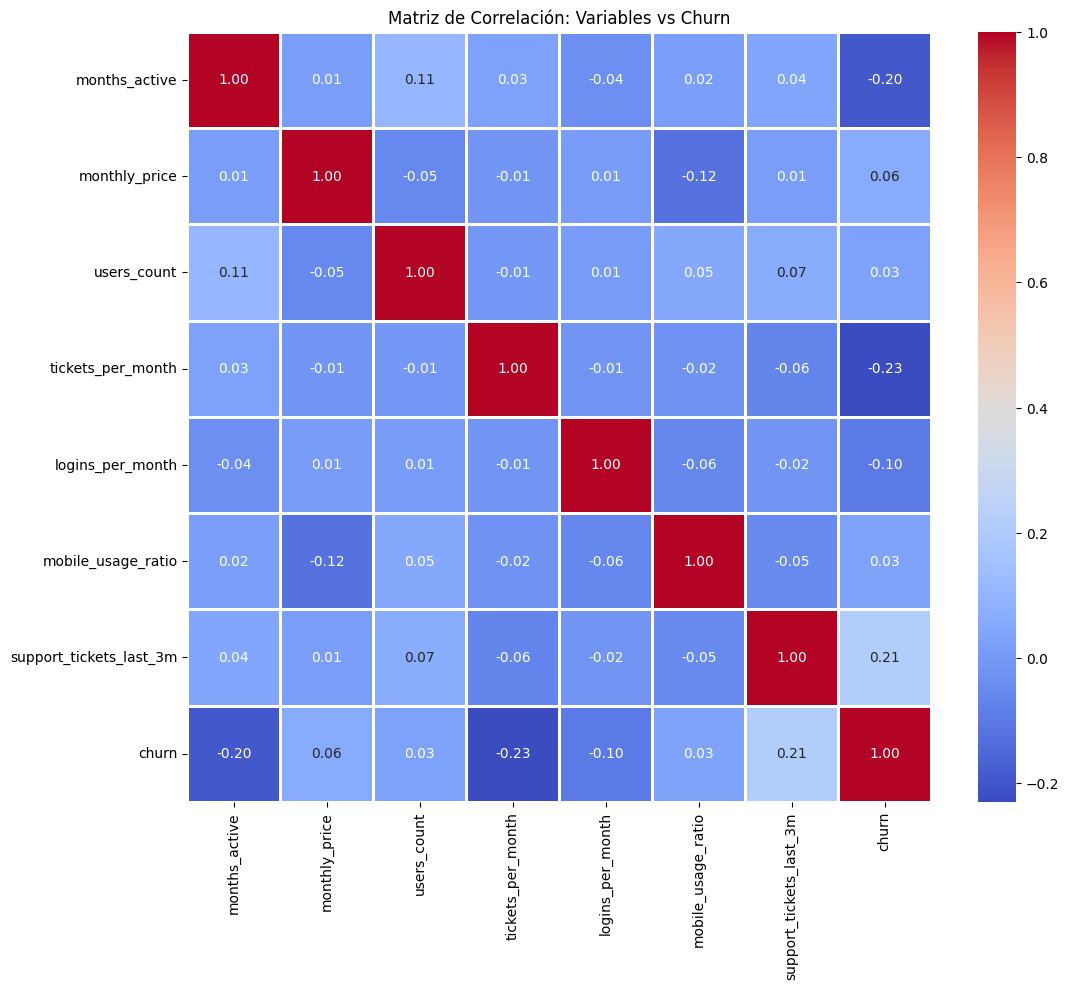

In [23]:
cols_to_corr = numerical_cols + ['churn']
corr_matrix = df[cols_to_corr].corr()

# Graficamos el mapa de calor (Heatmap)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.8)
plt.title('Matriz de Correlación: Variables vs Churn')
plt.show()

1. Los "Culpables" del Churn (Correlaciones más altas)

Fíjate en la última fila o columna (la de churn). Los números más alejados de cero son tus variables clave:

    tickets_per_month (-0.23): Esta es la correlación negativa más fuerte. Indica que, curiosamente, los clientes que tienen un volumen de tickets menor en el promedio histórico tienden a tener más churn. Esto podría sugerir "desconexión": el cliente deja de reportar problemas porque ya ha decidido irse.

    support_tickets_last_3m (0.21): Correlación positiva clara. A medida que aumentan los tickets en los últimos 3 meses, aumenta el riesgo de churn. Es el "humo" antes del incendio.

    months_active (-0.20): Correlación negativa. Confirmamos que a mayor antigüedad, menor es el riesgo de que el cliente se vaya. Los clientes nuevos son los más vulnerables.

2. Los "Inocentes" (Correlaciones cercanas a 0)

Estas variables casi no tienen relación lineal con el churn. Si el modelo de IA fuera una persona, casi no les prestaría atención para decidir si alguien se va:

    users_count (0.03) y mobile_usage_ratio (0.03): El tamaño de la empresa y cómo usan el móvil no afectan la lealtad.

    monthly_price (0.06): El precio tiene un impacto bajísimo. Los clientes no se van por dinero, se van por servicio o falta de uso.

3. Diagnóstico de Salud del Dataset

    No hay Multicolinealidad: No veo ninguna pareja de variables (fuera de la diagonal principal) que tenga un valor cercano a 1.0 o -1.0. Esto es bueno, porque significa que cada variable aporta información única y no estás repitiendo datos innecesariamente.

    Relaciones Débiles: Nota que las correlaciones máximas están en el rango de 0.20 a 0.23. Esto indica que el churn es un fenómeno complejo. No hay una sola variable que lo explique todo; vas a necesitar la combinación de varias para que tu modelo sea preciso.

## Conclusiones del Análisis Exploratorio de Datos (EDA)
Tras analizar el comportamiento de los clientes y su relación con la pérdida de servicio (Churn), se han identificado los siguientes patrones clave:

1. Factores Críticos de Abandono

Antigüedad del Cliente (months_active): Existe una relación inversa clara; a menor antigüedad, el riesgo de Churn es significativamente mayor. Los clientes en sus primeros 25-30 meses de vida son los más vulnerables.

Soporte Técnico (support_tickets_last_3m): El aumento de incidencias en los últimos 3 meses es un predictor positivo de abandono. Los clientes que se van suelen promediar 10 tickets, frente a los 6 de los clientes que permanecen.

Desconexión del Usuario (tickets_per_month): Curiosamente, los clientes con menor volumen de tickets en su promedio histórico muestran una mayor tendencia al Churn (correlación de -0.23). Esto sugiere que la falta de interacción con el soporte puede ser un síntoma de desuso previo a la cancelación.

2. Factores de Bajo Impacto (Inocentes)

Precio Mensual (monthly_price): No existe una diferencia significativa en la tasa de Churn entre los distintos planes de precios. El cliente no parece abandonar el servicio por razones estrictamente económicas.

Tamaño de la Empresa (users_count): El número de usuarios activos por cuenta no garantiza la lealtad ni acelera el abandono. El riesgo es similar para empresas pequeñas y grandes.

3. Diagnóstico de los Datos

Desbalance de Clases: El dataset presenta un 14.4% de Churn frente a un 85.6% de retención. Esto requerirá técnicas específicas de balanceo (como sobremuestreo o ajuste de pesos) al entrenar el modelo de IA.

Calidad de la Información: No se detectaron outliers extremos en las variables numéricas, lo que indica que los datos son consistentes y no requieren limpiezas agresivas antes del modelado.